# DSCI 100 - Report
### project-003-7: Nicole Campbell, Michelle Kim, Jason Liu, Zahra Raza

## Introduction

[WE NEED TO CHANGE THIS]
Our project is centered around factors that influence a student’s decision to pursue higher education based on academic performance. A student’s academic performance is often affected by different social and environmental factors. Thus, objective analysis on the relationship between those factors is critical to bolster maximum academic success. 
 
We will be working with the data set “Student Performance”, collected by Paulo Cortez at the University of Minho. The data set contains information gathered from students at two Portugese secondary students. The information collected includes student grades, social and study habits, and family background. The data set tracks first and second period grades as well as final grades in Portugese
 
We will try to answer the following question in this report:
Can we predict a student's study time, given Portuguese grades or math grades?

## Methods and Results

In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

First, we loaded our data directly from github.

The origianal file includes both math and portuguese, but we only downloaded math dataframe becasue we are only going to use math grades to predict students studytime.

Then selected only the variables of interest out of i-dont-know-how-many variables. 

*describe variables*

Declared studytime as a factor since that is what we want to categorize students based on their math grades.

Splited the whole dataset into training and testing sets. 

Used prop = 0.75 since the dataset in total has x number of students which is small enough that we will get reasonable amount of trainign adn testing data with this split. 

In [2]:
set.seed(400);

#Read data set from the web into R
student_mat <- read_delim("https://raw.githubusercontent.com/michelleykim/student_performance_analysis/main/data/student-mat.csv", delim = ";")

# Clean and wrangle data into tidy format
mat_select <- student_mat %>%
                select("studytime", "G1", "G2", "G3") %>%
                mutate(studytime = as_factor(studytime))

# Obtain training set:
# We chose prop= 0.75 since the data set is small enough that we will still 
# have a reasonable amount of training and testing data with this split.
mat_split <- initial_split(mat_select, prop = 0.75, strata = studytime) 
mat_train <- training(mat_split)
mat_test <- testing(mat_split)


Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



We decided to use K-NN classification rather than regression because the data collected studytime as a categorical variable. 

We didn't scaled or centered the data since the original data was already scaled and centered by the institution.

Choose v = 5 since we thought that would give us enough folding while not taking up too mcuh time.

Then we plotted the accuracies for each neighbours to choose k value. 

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


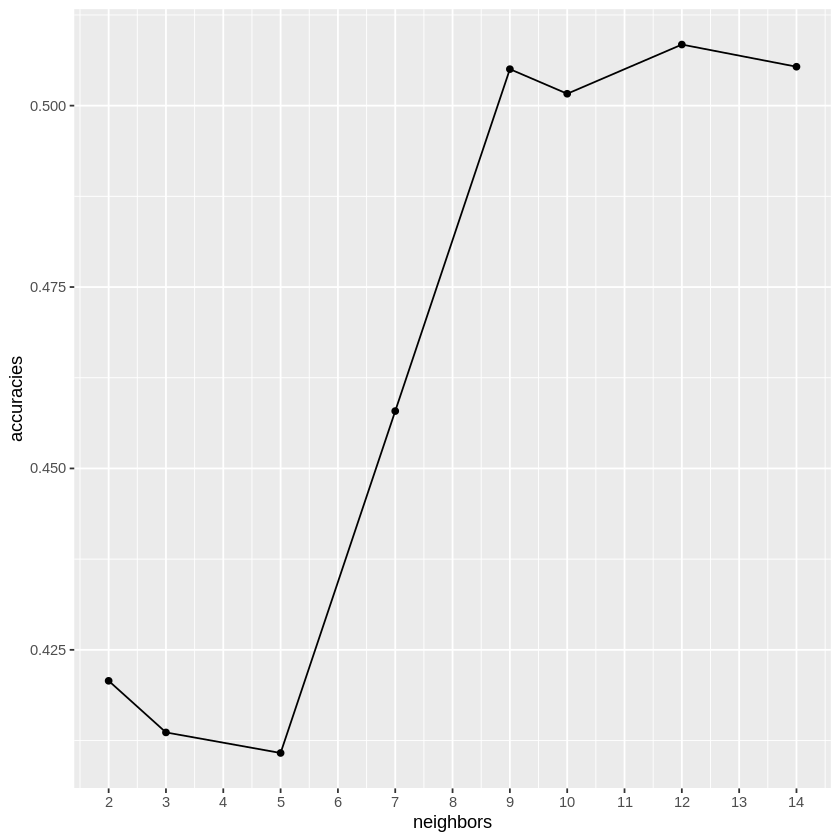

In [3]:
set.seed(400);

# vfold_cv
mat_vfold <- vfold_cv(mat_train, v = 5, strata = studytime)

# balancing
mat_overpop_recipe <- recipe(studytime ~., data = mat_train) %>%
        step_upsample(studytime, over_ratio = 1, skip = FALSE) %>%
        prep()
mat_overpop <- bake(mat_overpop_recipe, mat_train)

#recipe
mat_recipe <- recipe(studytime ~., data = mat_overpop)

# nearest_neighbour
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
        set_engine("kknn") %>%
        set_mode("classification")

# workflow & tune_grid
knn_workflow <- workflow() %>%
        add_recipe(mat_recipe) %>%
        add_model(knn_spec) %>%
        tune_grid(resamples = mat_vfold, grid = 10) %>%
        collect_metrics()

# produce accuracy graph to determine the k value
accuracies <- knn_workflow %>%
        filter(.metric == "accuracy")
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "neighbors", y = "accuracies") +
        scale_x_continuous(breaks = seq(0, 15, by = 1))

cross_val_plot

Based on the cross validation graph, the nearest_neighbor algorithm give the highest accuracy when 9 neighbors were used for prediction. 


Although the highest accuracies showed when 12 neighbors were used but we were worried that going over 10 neighbors would cause ...

Also, since the difference in accuracies between using 9 neighbors and 12 neighbours is small, which leaves both being potentially the optimal accuracy. 

Using the K value determined from the graph, we predict the studytime of testing set data and found the accuracy 

In [4]:
set.seed(400);

# nearest_neighbour with k = 9, workflow 
mat_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>%
        set_engine("kknn") %>%
        set_mode("classification")

mat_fit <- workflow() %>%
        add_recipe(mat_recipe) %>%
        add_model(mat_spec) %>%
        fit(data = mat_train)

# predict
mat_predictions <- predict(mat_fit, mat_test) %>%
        bind_cols(mat_test)

# maybe do metrics, conf_mat
mat_metrics <- mat_predictions %>%
        metrics(truth = studytime, estimate = .pred_class)
mat_conf_mat <- mat_predictions %>%
        conf_mat(truth = studytime, estimate = .pred_class)

# print
mat_predictions
mat_metrics
mat_conf_mat

.pred_class,studytime,G1,G2,G3
<fct>,<fct>,<dbl>,<dbl>,<dbl>
2,2,5,5,6
2,2,7,8,10
2,2,6,10,10
⋮,⋮,⋮,⋮,⋮
1,2,7,9,8
1,2,6,5,0
2,1,14,16,16


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4897959
kap,multiclass,0.1073055


          Truth
Prediction  1  2  3  4
         1  8  6  2  1
         2 15 39 12  9
         3  2  3  1  0
         4  0  0  0  0

## Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## Reference
P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7. https://archive.ics.uci.edu/ml/datasets/Student+Performance#
